<a href="https://colab.research.google.com/github/teoad95/Deep-learning-Cryptocurrency-price-prediction/blob/main/Etherium_prediction_thodoris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [2]:
pwd

'C:\\Users\\georg\\Documents\\GitHub\\Deep-learning-Cryptocurrency-price-prediction'

In [16]:
# get market info for bitcoin from the start of 2016 to the current day

eth_market_info = pd.read_csv('EthereumDataset.csv')
eth_market_info.index

RangeIndex(start=0, stop=2414, step=1)

In [17]:
eth_market_info = eth_market_info.dropna(how='any',axis=0) 
eth_market_info['Date'] = pd.to_datetime(eth_market_info['Date'])


In [18]:
# convert the date string to the correct date format
#eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
# when Volume is equal to '-' convert it to 0
eth_market_info.loc[eth_market_info['Volume']=="-",'Volume']=0
# sometime after publication of the blog, coinmarketcap starting returning asterisks in the column names
# this will remove those asterisks
eth_market_info.columns = eth_market_info.columns.str.replace("*", "")

In [19]:
eth_market_info['Date']

0      2014-09-19
1      2014-09-20
2      2014-09-21
3      2014-09-22
4      2014-09-23
          ...    
2409   2021-04-24
2410   2021-04-25
2411   2021-04-26
2412   2021-04-27
2413   2021-04-28
Name: Date, Length: 2410, dtype: datetime64[ns]

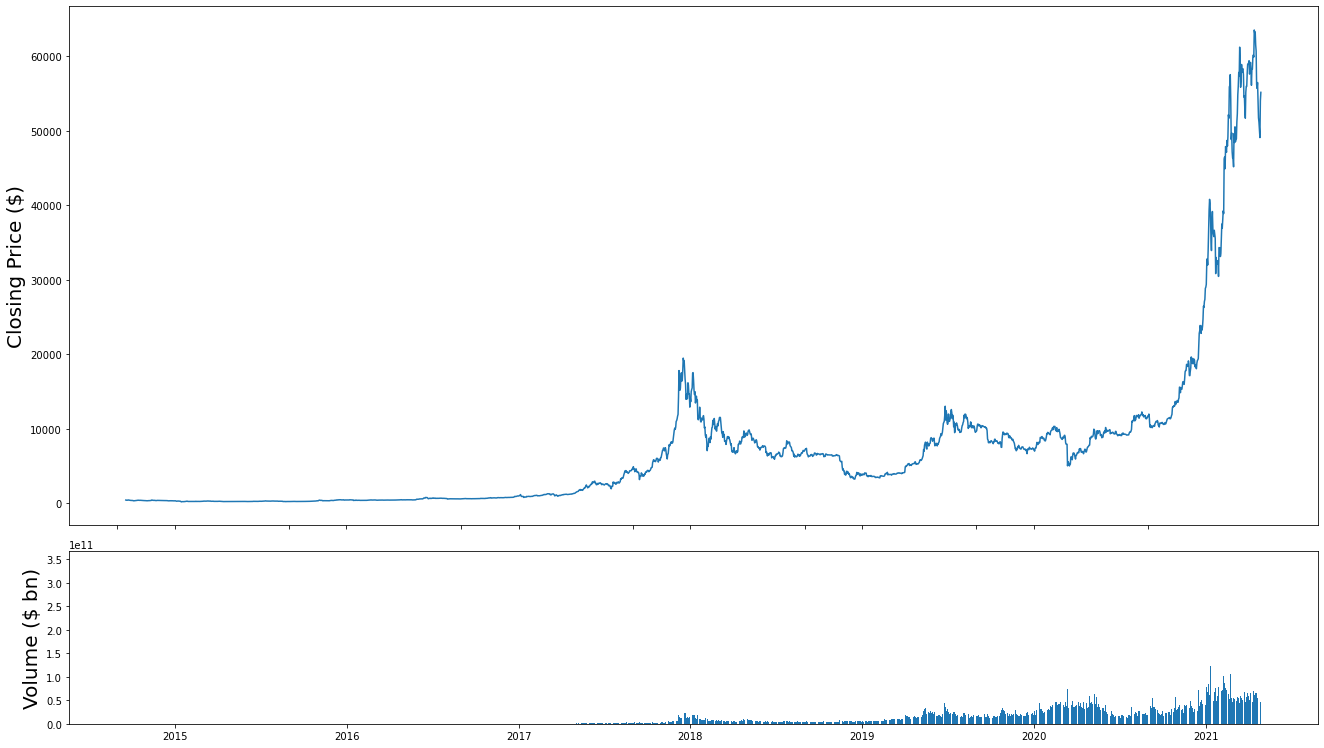

In [20]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
#ax1.set_yscale('log')
ax1.set_ylabel('Closing Price ($)',fontsize=20)
ax2.set_ylabel('Volume ($ bn)',fontsize=20)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2021) for j in [1,9]])
ax1.set_xticklabels('')
ax1.plot(eth_market_info['Date'],eth_market_info['Open'])
ax2.bar(eth_market_info['Date'], eth_market_info['Volume'].values)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()

plt.show()

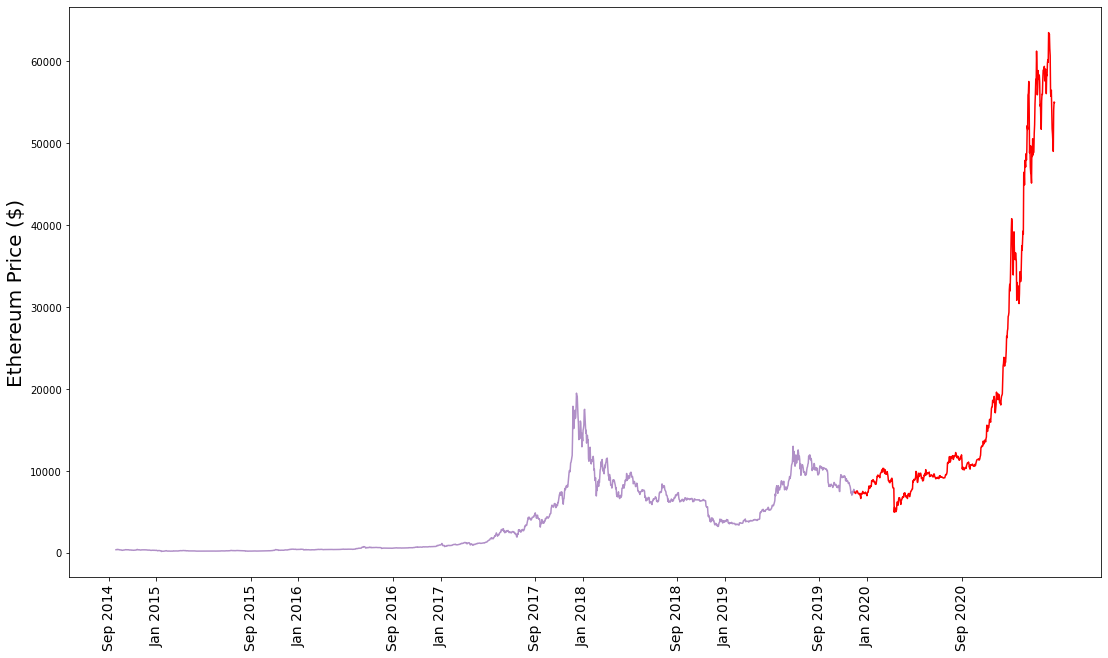

In [21]:
split_date = '2019-12-01'
fig, (ax2) = plt.subplots(1,1)
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2021) for j in [1,9]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2021) for j in [1,9]])
ax2.plot(eth_market_info[eth_market_info['Date'] < split_date]['Date'],
         eth_market_info[eth_market_info['Date'] < split_date]['Close'], 
         color='#B08FC7')
ax2.plot(eth_market_info[eth_market_info['Date'] >= split_date]['Date'],
         eth_market_info[eth_market_info['Date'] >= split_date]['Close'], color='red')
ax2.set_ylabel('Ethereum Price ($)',fontsize=20)
fig.set_size_inches(18.5, 10.5)
plt.xticks(fontsize=14, rotation=90)
plt.show()

In [22]:
kwargs = {'day_diff': lambda x: (x['Close']-x['Open'])/x['Open'],
          'close_off_high': lambda x: 2*(x['High']- x['Close'])/(x['High']-x['Low'])-1,
          'volatility': lambda x: (x['High']- x['Low'])/(x['Open'])}
eth_market_info = eth_market_info.assign(**kwargs)

In [23]:
model_data = eth_market_info.sort_values(by='Date')
# we don't need the date columns anymore
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [24]:
window_len = 10

In [25]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in ['Close','Volume']:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1

In [26]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in ['Close','Volume']:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

In [27]:
LSTM_training_inputs[0]

,Open,High,Low,Close,Adj Close,Volume,day_diff,close_off_high,volatility
0,424.102997,427.834991,384.532013,0.000000,394.795990,0.000000,-0.069104,0.525946,0.102105
1,394.673004,423.295990,389.882996,0.035735,408.903992,-0.027851,0.036058,-0.138539,0.084660
2,408.084991,412.425995,393.181000,0.010195,398.821014,-0.299042,-0.022701,0.413872,0.047159
3,399.100006,406.915985,397.130005,0.018632,402.152008,-0.363719,0.007647,-0.026367,0.024520
4,402.092010,441.557007,396.196991,0.103838,435.790985,0.189342,0.083809,-0.745766,0.112810
5,435.751007,436.112000,421.131989,0.071959,423.204987,-0.192301,-0.028792,0.723231,0.034377
6,423.156006,423.519989,409.467987,0.042498,411.574005,-0.292864,-0.027371,0.700254,0.033208
7,411.428986,414.937988,400.009003,0.024390,404.424988,-0.434046,-0.017024,0.408401,0.036286
8,403.556000,406.622986,397.372009,0.011966,399.519989,-0.603655,-0.010001,0.535621,0.022924
9,399.471008,401.016998,374.332001,-0.044618,377.181000,-0.377281,-0.055799,0.786472,0.066801


In [28]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [29]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [30]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
1889/1889 - 5s - loss: 0.2703
Epoch 2/50
1889/1889 - 3s - loss: 0.1037
Epoch 3/50
1889/1889 - 3s - loss: 0.0963
Epoch 4/50
1889/1889 - 3s - loss: 0.0962
Epoch 5/50
1889/1889 - 3s - loss: 0.0960
Epoch 6/50
1889/1889 - 3s - loss: 0.0964
Epoch 7/50
1889/1889 - 3s - loss: 0.0958
Epoch 8/50
1889/1889 - 3s - loss: 0.0964
Epoch 9/50
1889/1889 - 3s - loss: 0.0958
Epoch 10/50
1889/1889 - 3s - loss: 0.0965
Epoch 11/50
1889/1889 - 3s - loss: 0.0959
Epoch 12/50
1889/1889 - 3s - loss: 0.0961
Epoch 13/50
1889/1889 - 3s - loss: 0.0960
Epoch 14/50
1889/1889 - 3s - loss: 0.1010
Epoch 15/50
1889/1889 - 3s - loss: 0.0966
Epoch 16/50
1889/1889 - 3s - loss: 0.0961
Epoch 17/50
1889/1889 - 3s - loss: 0.0961
Epoch 18/50
1889/1889 - 3s - loss: 0.0966
Epoch 19/50
1889/1889 - 3s - loss: 0.0966
Epoch 20/50
1889/1889 - 3s - loss: 0.0968
Epoch 21/50
1889/1889 - 3s - loss: 0.0967
Epoch 22/50
1889/1889 - 3s - loss: 0.0962
Epoch 23/50
1889/1889 - 3s - loss: 0.0964
Epoch 24/50
1889/1889 - 3s - loss: 0.0961
E

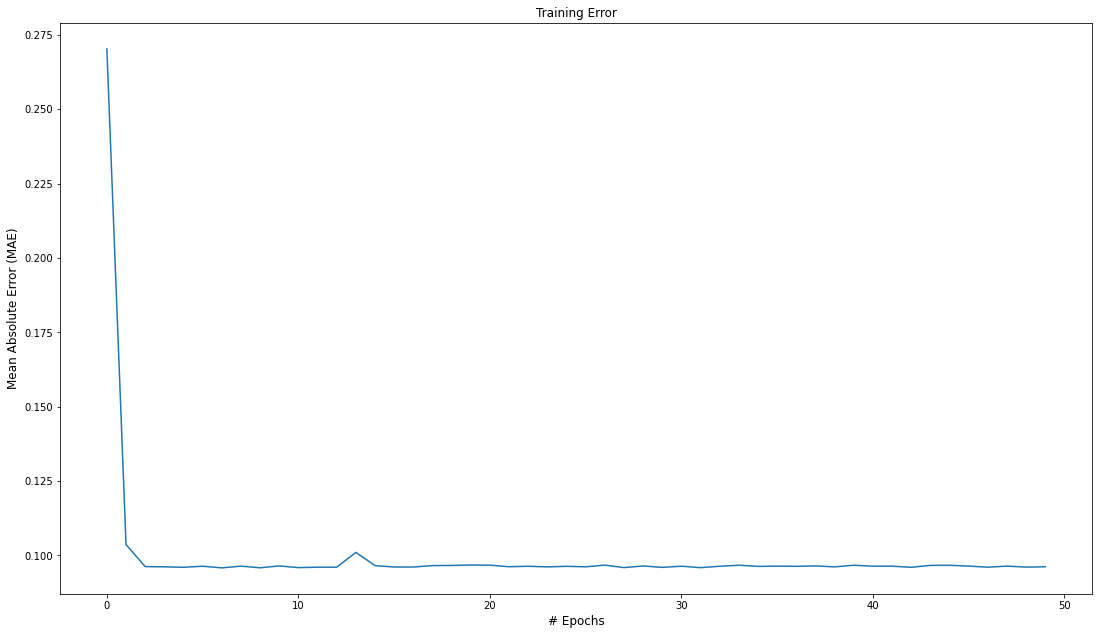

In [31]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Training Error')

if eth_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
fig.set_size_inches(18.5, 10.5)
plt.show()

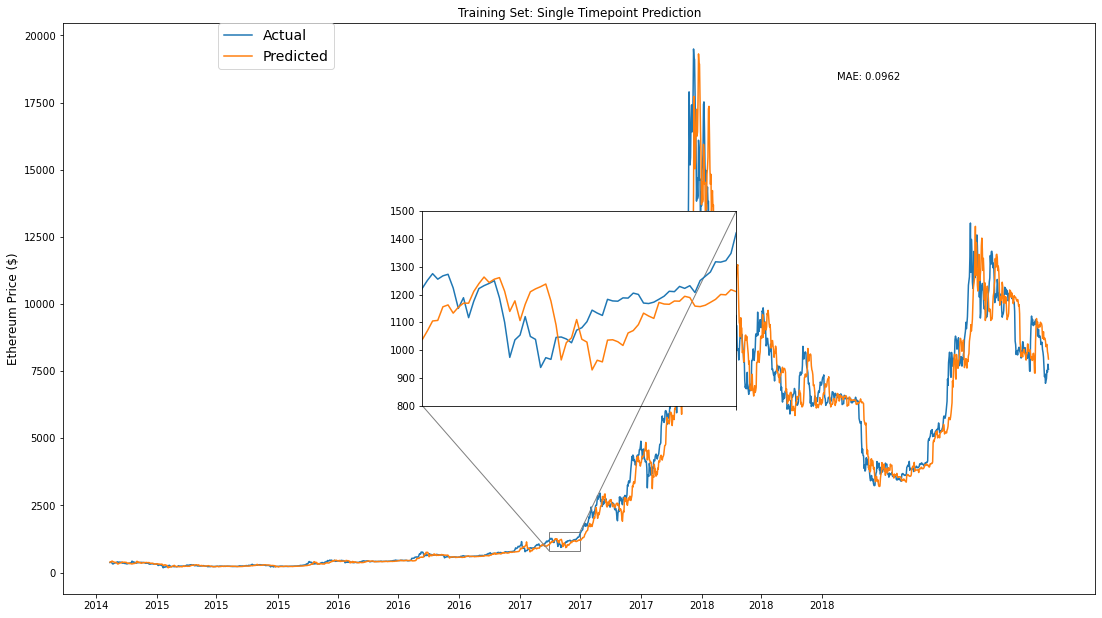

In [37]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
#ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2021) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         training_set['Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_training_inputs))+1)-\
            (training_set['Close'].values[window_len:])/(training_set['Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 10.35, loc=10) # zoom-factor: 3.35, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         training_set['Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 3, 1), datetime.date(2017, 5, 1)])
axins.set_ylim([800,1500])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
fig.set_size_inches(18.5, 10.5)
plt.show()


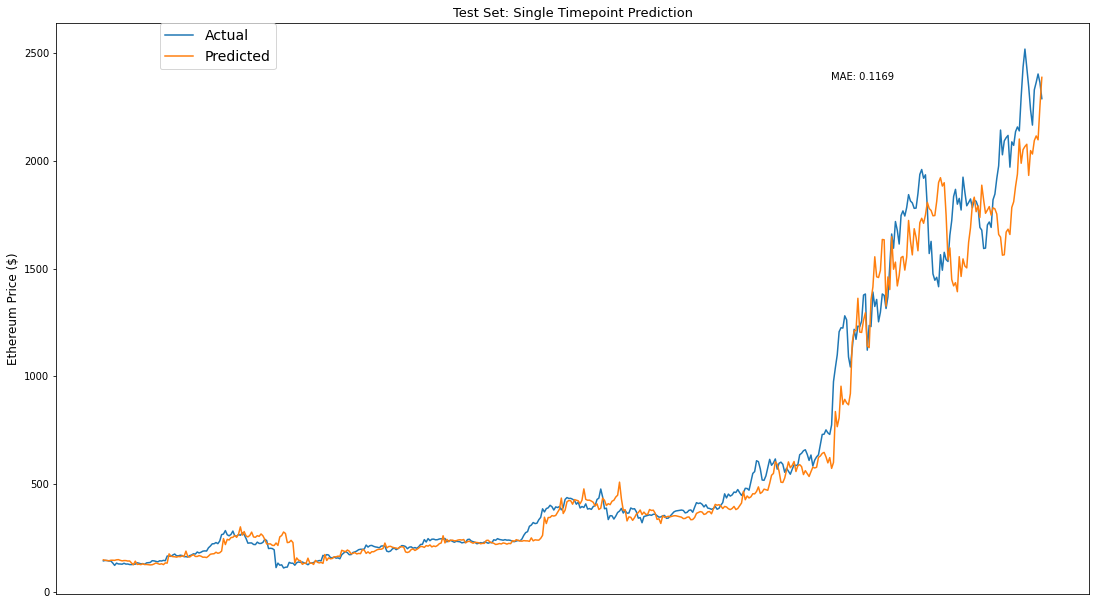

In [56]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:],
         test_set['Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:],
         ((np.transpose(eth_model.predict(LSTM_test_inputs))+1) * test_set['Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_test_inputs))+1)-\
            (test_set['Close'].values[window_len:])/(test_set['Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
fig.set_size_inches(18.5, 10.5)
plt.show()

In [40]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 5
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['Close'])-pred_range):
    LSTM_training_outputs.append((training_set['Close'][i:i+pred_range].values/
                                  training_set['Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
1884/1884 - 4s - loss: 0.1799
Epoch 2/50
1884/1884 - 3s - loss: 0.1088
Epoch 3/50
1884/1884 - 3s - loss: 0.1060
Epoch 4/50
1884/1884 - 3s - loss: 0.1056
Epoch 5/50
1884/1884 - 3s - loss: 0.1053
Epoch 6/50
1884/1884 - 3s - loss: 0.1055
Epoch 7/50
1884/1884 - 3s - loss: 0.1054
Epoch 8/50
1884/1884 - 3s - loss: 0.1056
Epoch 9/50
1884/1884 - 3s - loss: 0.1058
Epoch 10/50
1884/1884 - 3s - loss: 0.1058
Epoch 11/50
1884/1884 - 3s - loss: 0.1055
Epoch 12/50
1884/1884 - 3s - loss: 0.1057
Epoch 13/50
1884/1884 - 3s - loss: 0.1057
Epoch 14/50
1884/1884 - 3s - loss: 0.1058
Epoch 15/50
1884/1884 - 3s - loss: 0.1054
Epoch 16/50
1884/1884 - 3s - loss: 0.1056
Epoch 17/50
1884/1884 - 3s - loss: 0.1057
Epoch 18/50
1884/1884 - 3s - loss: 0.1057
Epoch 19/50
1884/1884 - 3s - loss: 0.1054
Epoch 20/50
1884/1884 - 3s - loss: 0.1053
Epoch 21/50
1884/1884 - 3s - loss: 0.1055
Epoch 22/50
1884/1884 - 3s - loss: 0.1056
Epoch 23/50
1884/1884 - 3s - loss: 0.1058
Epoch 24/50
1884/1884 - 3s - loss: 0.1058
E

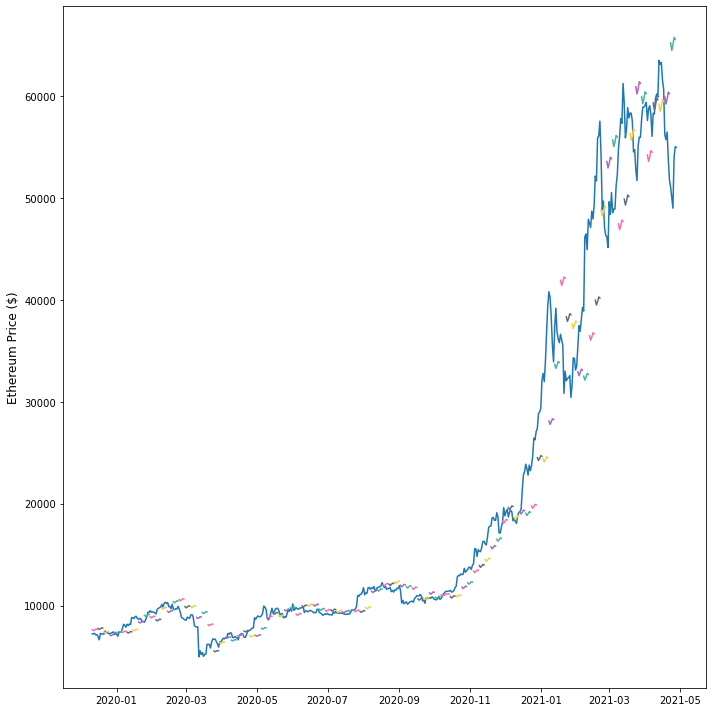

In [50]:
# little bit of reformatting the predictions to closing prices
eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))
pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D"]
fig, (ax2) = plt.subplots(1,1, figsize=(10, 10))

#ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
#ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:],
         test_set['Close'][window_len:], label='Actual')
for i, eth_pred in enumerate(eth_pred_prices):
    
    # Only adding lines to the legend once
    if i<5:
        ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:][i*pred_range:((i*pred_range)+pred_range)],
                 eth_pred, color=pred_colors[i%5], label="Predicted")
    else: 
        ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:][i*pred_range:i*pred_range+pred_range],
                 eth_pred, color=pred_colors[i%5])
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
fig.tight_layout()
plt.show()

In [46]:
model_data[model_data['Date']>= split_date]['Date']

1899   2019-12-01
1900   2019-12-02
1901   2019-12-03
1902   2019-12-04
1903   2019-12-05
          ...    
2409   2021-04-24
2410   2021-04-25
2411   2021-04-26
2412   2021-04-27
2413   2021-04-28
Name: Date, Length: 511, dtype: datetime64[ns]